<a href="https://colab.research.google.com/github/oleo2003/group_5_repo/blob/main/2)_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(**Note:**
Click on the button that reads *“Open in Colab”* to open this code in Google Colab. Once open in Google Colab, you can make a copy of the notebook in your personal drive and run the code by clicking a little triangle/arrow to the left of each code block.)

# **Logistic Regression**

## ***Objectives for this Notebook***
- Learn the basics of how logistic regression model works.
- Create functions to implement Logistic Regression to Moradigaravand's dataset.

**Logistic Regression** is a classification model that allows us to predict the probability for a binary outcome (2 classes). Typically the threshold for logistic regression is 0.5; In our example, this means that above this probability, the model would predict **R** (Resistant) and below this it will predict **S** (Susceptible).

The equation for Logistic Regression is derived from Linear Regression, but instead of using the response variable Y, it employs the natural log of the odds:

$$ ln(\frac{P}{1-P}) = \hat \beta_0 + \hat \beta_jX$$

After isolating P, we end up with the equation below:

$$P = \frac{e^{\hat{\beta}_{0}+\hat{\beta}_{j}X}}{1+e^{\hat{\beta}_{0}+\hat{\beta}_{j}X}}$$

- ***P*** is the probability of an outcome. Therefore P is a number between 0(0%) and 1(100%). To make a binary prediction (Resistant or Susceptible), we use a threshold of 0.5. For our example if P < 0.5 our model would predict Susceptible (S) and if P > 0.5 our model would predict Resistant (R)

- $\hat \beta_0$ is the intercept term and $\hat \beta_j = [\beta_1 , \beta_2 , \beta_3, ... , \beta_{17199}]$ are the coefficients for each of our features, which the model will try to estimate using our data, there is one coefficient per column feature and we are estimating 17199 (!) of them in our example.

- $X = [Year \ column + Gene \ Absence \ and \ Presence \ columns]$

We will see each of the parts of this equation as we go along in the tutorial, so we can have better picture of these.

A full understanding of the math behind the logistic regression model is not necessary. Using a logistic regression model (or any other machine learning model) doesn't require a detailed understanding of the math behind it. It is important however to know when to implement particular models. For instance, logistic regression is usually suitable for predicting binary labels, such in this case, where we have to determine either R or S for each isolate.



### **1) Importing Packages needed**


In [22]:
# Data manipulation imports for ML
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

# Import packages for logistic regression model and hyperparameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV

# Imports for model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, get_scorer_names
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import StratifiedGroupKFold, KFold
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

# Imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for file management
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **2) Loading CSV file and creating dataframes for each antibiotic**
In here we will be loading the CSV we created in the previous notebook. This file should contain information on resistance to all the antibiotic drugs (Labels) and all the Years of isolation , Gene Presence/Absence data (Features) and the Sequence Type data.


In [23]:
# Loads csv file as a dataframe
# If the file is "not found" go back to Notebook 1 to make sure you create the file in your Drive.
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

# reads csv file as a dataframe
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")
All_Drugs_df.head()

/tmp/ipython-input-2706555092.py:6: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,S,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0


### **3) Separating each Drug Dataframe into 4 sections : Training features, training labels, testing features and testing labels.**

The objective of this part will be to first create a single dataframe for each antibiotic drug and then split that data frame into 4 parts (see below). The dataframe will have all our features and the label for only one drug. This is because Resistance and Susceptibility are not universal. For example, just because an isolate of *E. coli* is resistant to say AMP (Ampicilin), it doesn't mean that is resistant to CIP (Ciprofloxacin). We will be training ML models for each of the antibiotics separately.

Below we can check the list of antibiotics again:




In [24]:
#here we make a list of the antibiotics in our combined dataframe
drug_list = All_Drugs_df.iloc[:,3:15].columns
drug_list

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')

After making the individual dataframes for each drug, we will split each of our 12 antibiotic dataframes into 4 different sections:

**Two TRAINING sections**

**a) labels_train:** are the labels (S or R) for a single antibiotic drug that will be used to teach our model how to make predictions.

**b) features_train:** are the features that will be used along with the labels_train to teach our model to make predictions. Note that this is actually the X matrix in our logistic equation! They will be used to estimate our $\beta_0$ and all the $\beta_j$ values with a process called *Maximum Likelihood*. You can watch the mathematical details of how this is done by watching this [video](https://www.youtube.com/watch?v=BfKanl1aSG0) by Josh Starmer

**Two TESTING sections**

**c) labels_test:** are the labels we will holding out so that we can see at the end if we made accurate predictions.

**d) features_test:** are the X values we will plug into our model, once $\beta_0$ and all the $\beta_j$ values have already been estimated.

- Below we create a function that will be used to separate each of our 12 dataframes (for 12 drugs) into the 4 separate parts described above. We also specify that 20% of our data to be used as a testing set and thus 80% of our data remains to become our training set. You can choose a different percentage to split them, but know that the majority of our data should be used for training.

In addition, the function we create to make these 4 sections will save the 4 parts into a python Dictionary object. If you are unfamiliar with what a dictionary is in python, feel free to check out this useful [link](https://docs.python.org/3/tutorial/datastructures.html#dictionaries). This way we can organize and access our 4 data chunks for a specific antibiotic drug.

**The function created below will create a dataframe and split the data in Training (labels and features) and Testing (labels and features) for each antibiotic.**

In [25]:
# Separating each dataframe into Labels and Features for training and testing data.
# Our function uses the handy train_test_split() function.

def Split_train_test_antibiotic(drug):
  #here we make a list of the columns we want to keep: the column for the isolate, the column for the drug we are interested in and all features (starting from column 15).
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  #here we create a data frame with just the columns we wanted to keep.
  Drug_df = pd.concat(df_list, axis=1)

  #here we drop all rows with missing data
  Drug_df = Drug_df.dropna()

  # Creating a dictionary to store each antibiotic datasets
  Train_test_dic = {}

  # Defining the label columns
  labels = Drug_df[drug]

  # Defining features columns
  features = Drug_df.drop(columns=[drug])

  # Separating training (features and labels) and testing (features and labels) datasets
  # We use stratify=labels so that the fraction resistant samples is the same in the test and the train sections
  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)

  # storing each data chunk in a dictionary
  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [26]:
# Implementing the function Split_train_test_antibiotic() for CTZ example
CTZ_Train_test_dic = Split_train_test_antibiotic("CTZ")

# checking the shape of each dataframe or series stored in the dictionary created for drug CTZ
print("CTZ")
for k, df in CTZ_Train_test_dic.items():
  print(k, df.shape)

CTZ
labels_train (1501,)
features_train (1501, 17201)
labels_test (376,)
features_test (376, 17201)


Below we can see a count of Susceptible and Resistance strains for the Training and Testing datasets. Notice that there are a lot more Susceptible than Resistant *E. coli* isolates to CTZ drug. This is good news for us as humans (most *E. coli* are susceptible to most drugs), but for ML approaches it can be a problem. This is considered an "inbalanced" dataset. Later on we will discuss how certain metrics may not be as reliable as others when looking at an imbalanced dataset.

In [27]:
# Accessing a particular chunk of data
print("Class Counts for Training Dataset:")
CTZ_Train_test_dic["labels_train"].value_counts()

Class Counts for Training Dataset:


,count
CTZ,
S,1295
R,206


In [28]:
# Accessing a particular chunk of data
print("Class Counts for Testing Dataset:")
CTZ_Train_test_dic["labels_test"].value_counts()

Class Counts for Testing Dataset:


,count
CTZ,
S,324
R,52


### **4) Creating different combinations of features before training**

The next part of this project is to add some complexity in our analysis by choosing specifically what sort of features we would like to include.

Recall that we have 2 types of features we went on detail on our [first notebook](https://colab.research.google.com/drive/13SbCF3LFXwM_jZELxQA4aBHUvPgfmzzP?usp=sharing):

- **Y**: Years of Isolation
- **G**: Gene presence and absence

We are interested in the following combinations: **G, Y** and **GY** This means that for any possible combination of feautures, we will train and test the machine learning models.

Below we create a function that will take the features dataframe (train or test) from the dictionary we have created in part 3 and then create dataframes with different feature combinations .

In [29]:
# making a list of combinations of data sources we would like to test in our ML models
combo_list = ['Y', 'G', 'GY']

# making a function that creates different feature combinations of the predictor features
def combo_feat(features_df, drug, combo):

  # Isolating Year as a feature and
  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  # creating Gene precence column filters for features_df
  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  # Note that we also make sure here that every set of features has the MLST column included.
  # We will drop that column later on when we train our models.
  # The reason we keep it here is so that we can use it later to do a "blocked cross validation" in step 8.

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df = pd.concat(df_list, axis=1)
    Y_feat_df = Y_feat_df.drop(columns=['Isolate'])
    return Y_feat_df

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

In [30]:
# Implementing combo_feat() function created for training data
CTZ_GY_train_feat = combo_feat(CTZ_Train_test_dic['features_train'],"CTZ","GY")

# looking only at the feature column names for the combination for "GY" for drug "CTZ" for training data
CTZ_GY_train_feat.columns

Index(['Year', 'MLST', 'yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB',
       'narQ',
       ...
       'group_48768', 'group_48873', 'group_48916', 'group_48933',
       'group_48937', 'group_48958', 'group_49020', 'group_49174',
       'group_49253', 'group_49257'],
      dtype='object', length=17200)

**NOTES:**

- We have **MLST** Sequence Type as a possible feature, but we will not use it as a feature in this tutorial. We will drop it for training the model.

- Later we can choose to use MLST for cross-validation purposes in order to increase generalizability of the ML models and avoid overfitting. This is important to consider because isolates that might have come from the same place, patient, etc. might have similar genetic composition and thus not be independent from each other.


### **5) Creating and Running Logistic regression model**

The next step involves creating a function that will actually create our Logistic Regression model and train it on our desired combination of training features and the labels for the drug we choose. While this function seems fairly straight forward, there is a lot of calculations happening in the backrgound when we call the LG.fit() function which trains our model. Notice that in this example function we are not considering the **MLST** column. We will only take a small peek at what's going on in the background.


In [31]:
# creating Logistic regression model function
@ignore_warnings(category=ConvergenceWarning)
def run_LG(feat_train_df, lab_train, drug, combo):
  feat=feat_train_df.drop(columns=['MLST'])
  print(drug +" Training combo: "+ combo)
  LG = LogisticRegression(random_state = 42, max_iter=500, class_weight='balanced')
  return LG.fit(feat, lab_train)

In [32]:
# implementing run_LG() for specific drug feature combination dataframe
LG_CTZ_GY_model = run_LG(CTZ_GY_train_feat, CTZ_Train_test_dic['labels_train'],"CTZ","GY")
LG_CTZ_GY_model

CTZ Training combo: GY


LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

In [33]:
# looking at what classes the model is able to predict
LG_CTZ_GY_model.classes_

array(['R', 'S'], dtype=object)

Below we can see that our model contains several coefficients. We will printout first the intercept ($\hat{\beta}_{0}$), then a list of the coefficients that correspond to each column feature ($\hat{\beta}_{j}$) and finally we can get a print out of the total number of coefficients in our model, these should be the same number as all the features we used in this example.

In [34]:
# printing the beta_0 or intercept value of our model
print("Intercept:",LG_CTZ_GY_model.intercept_[0])

# printing all the beta_j's or coefficients of our logistic regression model
print("All beta_j values:", LG_CTZ_GY_model.coef_[0])

# printing the number of all the beta_j values
print("Number of beta_j values: ", len(LG_CTZ_GY_model.coef_[0]))

Intercept: 0.003813499681956953
All beta_j values: [-0.00172753  0.00342149 -0.00059281 ...  0.          0.
  0.        ]
Number of beta_j values:  17199


### **6) Making predictions from Logistic regression model**

Now that our model has been trained and all $\beta$ values have been estimated, we are ready to make predictions! We will use the features of our testing data which we separated when we made our antibiotic drug dictionary.

Below we create another function where we predict labels using the actual model and the "features_test" chunk.


In [35]:
# creating a function using the model created and trained and the feature combinations from testing data
def predict(LG_combo_Model, features_test):
  feat = features_test.drop(columns=['MLST'])
  labels_pred = LG_combo_Model.predict(feat)
  if is_numeric_dtype(labels_pred):
    # tranforming labels from numbers to letters
    lab_pred_t = labels_pred.astype('O')
    lab_pred_t[lab_pred_t==0] = 'R'
    lab_pred_t[lab_pred_t==1] = 'S'
    return lab_pred_t
  else:
    return labels_pred

Below we will use the function **combo_feat()** to split the testing dataset

In [36]:
# Implementing combo_feat() function created for testing data
CTZ_GY_test_df = combo_feat(CTZ_Train_test_dic['features_test'],"CTZ","GY")

The we will implement the function **predict()** below:

In [37]:
# Implementation of the predict() function using the feature combination "GY"
CTZ_GY_labels_pred = predict(LG_CTZ_GY_model,CTZ_GY_test_df)

# observe how many predictions were made for each category "R" and "S"
print("Labels predicted: ", np.unique(CTZ_GY_labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([ 45, 331]))


We can see in the last output that index order for **R (Resistance is 0)** and for **S (Susceptible is 1)**, meaning that we predicted 42 Resistant and 334 Susceptible samples.

In [38]:
# let's look at the predictions for the first 30 isolates
print("Labels predicted for first 10 test isolates: ", CTZ_GY_labels_pred[:30])

# and the actual labels for the first 30 isolates – do they match?
print("Labels predicted for first 10 test isolates: ", np.array(CTZ_Train_test_dic['labels_test'][:30]))


Labels predicted for first 10 test isolates:  ['S' 'S' 'S' 'R' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S' 'S' 'S']
Labels predicted for first 10 test isolates:  ['S' 'S' 'S' 'R' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S' 'S' 'S']


### **7) Evaluating our model using a confusion matrix and metrics**
There are different ways we can evaluate our model. A **confusion matrix** is a plot showing a prediction summary for our model. It allows us to see how many predictions were correct and incorrect. There are also different metrics we can calculate using this graph. For this tutorial we will focus on three of them: **Accuracy**, **Recall** and **Precision**.

- **Accuracy:** is the total number of correct classifications over the total amount of predictions made.

- **Recall:** is the number of correct classifications made for a particular class over all predictions of that class.

- **Presicion:** is the number of classifications made for a particular class over the actual number of strains for that class.

Recall and Precision can each be calculated for resistance and for susceptibility.

When we have two classes, a 2 by 2 confusion matrix contains:

- **True Positives (TP)** = Resistant strains correctly classified as resistant (R) = 34
- **True Negatives (TN)** = Susceptible strains correctly classified as susceptible (S) = 316
- **False Positives (FP)** = Susceptoble strains incorrectly classified as resistant (R) = 8
- **False Negatives (FN)** = Resistant strains incorrectly classified as susceptible (S) = 18

In [39]:
# Creating a function that evaluates our model using our actual and predicted data
def evaluate(LG_combo_model, labels_test, labels_pred, cf= True, show_results=True):
  report = classification_report(labels_test, labels_pred, output_dict = True)
  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=np.unique(labels_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_pred))
    disp.plot()
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',report['accuracy'])
    print('R recall:',report['R']['recall'])
    print('S recall:',report['S']['recall'])
    print('R precision:',report['R']['precision'])
    print('S precision:',report['S']['precision'])
  return [report['accuracy'], report['R']['recall'], report['S']['recall'], report['R']['precision'], report['S']['precision']]

Before we implement our function we can show a manual way in which these metrics are calculated, first for the overall *Accuracy* and then *Recall* and *Precision* for only the Resistant strains (R) as an example:

|<font size=3>Metrics|<font size=3>General formula| <font size=3>Formula for 2 classes|<font size=3>Manual Calculation|
|--|:-:|:-:|:--|
|<font size=3>**Accuracy**|<font size=3>$\frac{Correctly \ classified}{All \ Predicted}$|<font size=3>$\frac{TP + TN}{TP + TN + FN + FP}$|<font size=3>$\frac{34 + 316}{376} = 0.931$|
|<font size=3>**R Recall:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Actual \ R}$|<font size=3>$\frac{TP}{TP + FN}$|<font size=3>$\frac{34}{34 + 18} = 0.654$|
|<font size=3>**R Precision:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Predicted \ R}$|<font size=3>$\frac{TP}{TP + FP}$|<font size=3>$\frac{34}{34 + 8} = 0.810$|


**NOTE:** In this tutorial we only work with 2 classes (R and S), thus the abbreviations (TP, TN, FP and FN) apply to our confusion matrix, however for situations with more than 2 classes, refer to the general formula column.

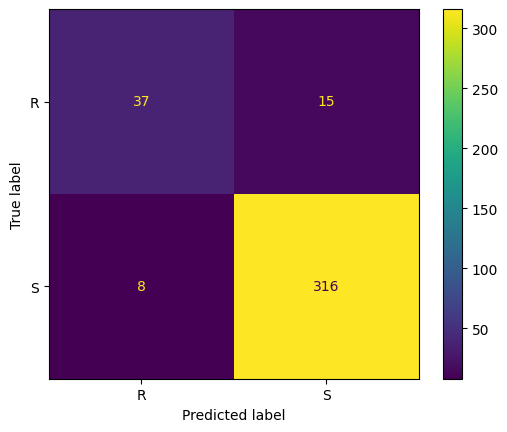

Results
Accuracy: 0.9388297872340425
R recall: 0.7115384615384616
S recall: 0.9753086419753086
R precision: 0.8222222222222222
S precision: 0.9546827794561934


In [40]:
# implementing the evaluate() function
Model_Report = evaluate(LG_CTZ_GY_model, CTZ_Train_test_dic['labels_test'], CTZ_GY_labels_pred)

Note that in this example, accuracy is 93.09%. That sounds quite good. But 18 out of the 52 of the resistant cases were misclassified as susceptible (recall score for R is only 65.4%). So, if the main goal here is to detect resistant strains, this particular model does not perform so well.

### **8) (OPTIONAL) Hyperparameter Tuning and Crossvalidation for LG model**

This section of the notebook is optional.
Here we will carry out hyperparameter tuning using cross-validation to optimize the model's performance and ensure its robustness. We will also include code to use a blocked cross-validation design. These approaches are important to make good ML models. However, if you are just here to learn the basics, feel free to skip section 8.




#### **a) Hyperparameter Tuning**
This is the process of modifying the way we train our data, every ML model has different hyperparameters we can tune in order to get the best results. The LG model used several default parameters that we could tune. For a complete list of hyperparameters and details of what each controls in the model, click [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

However, to keep this tutorial simpler we will perform tuning for just the hyperparameter **"C"**, which controls the amount of regularization. Regularization is a method to prevent overfitting. Overfitting means that the model will try to make perfect predictions for the training dataset, but these predictions will not generalize to other data.
With a small **"C"** the model will overfit less.

We start first by creating a dictionary of the parameters we would like to tune in our logistic regression model. You can see below that we will try to test 4 different values for the hyperparameter **"C"** :

In [41]:
# performing hyperparameter tuning for model
## Creating dictionary of parameters to tune.
hparam = {"C":[0.001, 0.01, 0.1, 1.00]}

#### **b) Crossvalidation**

In addition to regularization, there are other ways to prevent overfitting. Crossvalidation is a technique used during training to avoid overfitting. In it's simplest form the training dataset splits into different chunks of data, where each chunk takes turns to become a hold out chunk of data to be tested after training with the remaining chunks.

There are different crossvalidation schemes. We will first focus on a regular 4-fold cross validation scheme.

The function created below will be used to perform the **hyperparameter "C" tuning** using a regular **4-fold crossvalidation** scheme, meaning the training data will be randomly split in 4 chunks, where each of the chunks will take turns to be the a validation test set, while the remaining chunks are used for training. Therefore we will train 16 times, (4 values for "C" X 4 validation tests). The output of our function will be the best model found after the hyper parameter tuning and crossvalidation performed.

#### **c) Blocked Crossvalidation**

Some research papers within the field of population genetics prefer to take into account the population structure of the dataset, as several isolates may belong to the same sequence type, patient or phylogenetic group, therefore they prefer to apply crossvalidation schemes that perform group splits  (or blocked) crossvalidation. Here is a list of [different crossvalidation schemes](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) available in sklearn.

Others choose to reweight isolates depending on their group size, in order to give less importance to samples from the same group.

Here we will show how we can use the MLST data (Sequence Type data) to perform crossvalidation. This is a way to perform crossvalidation taking into account that some isolates might be highly related to others and therfore in order to keep our model as generalizable as possible, the training data is trained in a set of isolates belonging to  a particular ST but the validation testing is performed with isolates of a different set of ST groups. This technique has been applied for example in this [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7059009/).

Below we present the code to perform **blocked crossvalidation**, using the **MLST** column as the blocking factor. Others population structure factors used for blocking have been phylogenetical groups or SNP cutoff values, etc. The code is provided below for you to have the option to perform it, if you call the LG_hp_tune() function with cv = "blocked".



In [42]:
# Creating function to perform hyper parameter tuning of model
@ignore_warnings(category=ConvergenceWarning)
def LG_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  #creating logistic regression model
  model = LogisticRegression(random_state = 42, max_iter=500, class_weight='balanced', n_jobs=2)
  # performing the hyper parameter tuning using crossvalidation
  scoring_dic = {'f1_macro':make_scorer(f1_score , average='macro')}
  # isolating the features used for training
  feat = feat_train_df.drop(columns=["MLST"])
  # tranforming labels from letters to 0 & 1
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})
  # Fitting using grid search parameters depending on crossvalidation scheme used
  if str(cv).isnumeric():
    cv = KFold(cv)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t)
  elif cv == "blocked":
    groups= feat_train_df['MLST']
    cv = StratifiedGroupKFold(n_splits=4)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t, groups=groups)
  else:
    print("Please provide a valid crossvalidation scheme `blocked` or an integer")
  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

In [43]:
# Running the function created (takes long time)
LG_tuned = LG_hp_tune(hparam, CTZ_GY_train_feat, CTZ_Train_test_dic['labels_train'])

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/tmp/ipython-input-319366623.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})


[CV 1/4] END ....C=0.001; f1_macro: (train=0.734, test=0.751) total time=  23.1s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.732, test=0.696) total time=  22.1s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.746, test=0.665) total time=  20.9s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.738, test=0.692) total time=  20.8s
[CV 1/4] END .....C=0.01; f1_macro: (train=0.904, test=0.840) total time=  19.9s
[CV 2/4] END .....C=0.01; f1_macro: (train=0.899, test=0.795) total time=  21.2s
[CV 3/4] END .....C=0.01; f1_macro: (train=0.910, test=0.711) total time=  21.0s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.923, test=0.792) total time=  20.9s
[CV 1/4] END ......C=0.1; f1_macro: (train=0.988, test=0.867) total time=  19.6s
[CV 2/4] END ......C=0.1; f1_macro: (train=0.979, test=0.816) total time=  19.9s
[CV 3/4] END ......C=0.1; f1_macro: (train=0.988, test=0.769) total time=  21.0s
[CV 4/4] END ......C=0.1; f1_macro: (train=0.990, test=0.827) total time=  20.8s
[CV 1/4] END ......C=1.0; f1

Note that the function created used **f1 score** to search for the best C parameter. The f1 score is a widely used score to interpret results where there is an imbalance in classes, since there are more S (1295) than R (206) isolates for CTZ in our dataset. We used the f1_score macro average, which takes into account the f1 scores for each class (R & S) and averages them. f1 scores range from 0 to 1.

- At the end of our crossvalidation it shows that our best C parameter is 0.1
- The highest average f1 score macro obtained from both of the classes is 0.821

We can now use the improved (hyper parameter tuned ) model to predict labels.

In [44]:
# making predictions with best model from hyperparameter tuning
CTZ_GY_tuned_pred = predict(LG_tuned,CTZ_GY_test_df)

# observe how many predictions were made for each category "R" and "S"
print("Labels predicted: ", np.unique(CTZ_GY_tuned_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([ 45, 331]))


Below we can compare the evaluation between the model before and after tuning to see if there are any differences:

**BEFORE Hyperparameter Tuning**

Default C = 1.0


In [45]:
# Evaluation for LG model before tuning
Model_Report = evaluate(LG_CTZ_GY_model, CTZ_Train_test_dic['labels_test'], CTZ_GY_labels_pred, cf=False)

Results
Accuracy: 0.9388297872340425
R recall: 0.7115384615384616
S recall: 0.9753086419753086
R precision: 0.8222222222222222
S precision: 0.9546827794561934


**AFTER Hyperparameter Tuning**

Tuned C = 0.1

In [46]:
# Evaluation for LG model AFTER tuning
Tuned_Model_Report = evaluate(LG_tuned, CTZ_Train_test_dic['labels_test'], CTZ_GY_tuned_pred, cf=False)

Results
Accuracy: 0.9281914893617021
R recall: 0.6730769230769231
S recall: 0.9691358024691358
R precision: 0.7777777777777778
S precision: 0.9486404833836858


Above we see the difference between the regular vs the tuned model, we see that the scores do not defer dramatically, except that R recall is a bit better now. Take into account that we have only performed tuning on one hyperparameter, perhaps if we did tuning for more hyperparameters our results could have been even better, however for the purposes of this tutorial, we will leave it at that.


### **9) Use functions created and evaluate every drug in every feature combination!**

In this part we will combine all the functions we have created in order to get the results for different drug and feature combinations. You can choose whether to use the functions created in step 8 (will take longer but be more thorough) or those created before, with no parameter tuning (will be faster but a little less thorough).  

#### **a) Lets recall the list of drugs we have available and the combination of features we are interested in**

In [47]:
# let's check all drugs
print(drug_list)

# let's see all feature combinations we are interested in
print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['Y', 'G', 'GY']


#### **b) Create a loop that will go through all our functions using the lists above**

The code below will take fairly long to run because we will train and hyperparameter tune several logistic regression models using different feature combinations for each of the 12 antibiotic drugs. It will then be stored in a python dictionary and dataframe so it can be accessed later.

**NOTE:** Python Dictionaries, are common data structures within the python language that are very efficient at storing and retrieving information. It consists in key-value pairs, in our case each key is: drug_combo and the value is paired with are the metrics results.

In [52]:
for fname in os.listdir(filepath):
    if fname.endswith('LG_metrics_df.csv'):
        print("A csv with stored results for Logistic Regression has already been created. Please check your Google Drive directory.")
        break
else:
  # Lets use all our functions this time and save our report into a single data structure
  LG_model_metrics = {}

  for drug in drug_list:
    print(drug)
    # splits each drug df into a dictionary with testing and training data
    Test_Train_dic = Split_train_test_antibiotic(drug)
    for combo in combo_list:
      # Training each drug and combo features
      labels_train = Test_Train_dic["labels_train"]
      # create corresponding feature_df for training
      features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)
      print(drug+"_"+combo)

      # runs logistic regression model using the corresponding training feature_df
      LG_combo_model = run_LG(features_train, labels_train, drug, combo)

      #Optional: If you want to use the hyperparameter tuning step 8 use this line instead of the previous one:
      #LG_combo_model = LG_hp_tune(hparam, features_train, labels_train, v=0)

      # create corresponding feature_df for testing
      features_test = combo_feat(Test_Train_dic["features_test"], drug, combo)
      # generate predictions based on the feature combination tested
      labels_pred = predict(LG_combo_model, features_test)
      # loading the actual labels
      labels_test = Test_Train_dic["labels_test"]
      # Evaluating our model
      report = evaluate(LG_combo_model, labels_test, labels_pred, cf=False, show_results=False)
      # Saving the results into a dictionary
      LG_model_metrics[drug+"_"+combo] = report
      print(report)
  # convert dictionary into a dataframe
  LG_metrics = pd.DataFrame.from_dict(LG_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
  LG_metrics = LG_metrics.rename(columns = {'index':'Drug_combo'})

  # saving our metric results into a CSV file
  LG_metrics.to_csv(filepath+"LG_metrics_df.csv", index= False)


A csv with stored results for Logistic Regression has already been created. Please check your Google Drive directory.


### **10) Create a bar graph showing metrics for all drugs using GY combination of features**

Using the CSV we created above with all our results, we will create a bargraph to visualize metrics for every antibiotic that uses the feature combination GY (Gene Presence and Absence & Year of Isolate collection). In the graph below we are comparing Accuracy and Recall scores for both classes.

The code below serves to create a new directory to store all our Machine Learning plots and figures created. If you run the code more than once it will let you know that the figure has already been created in the directory.

A directory was already created to store your plot


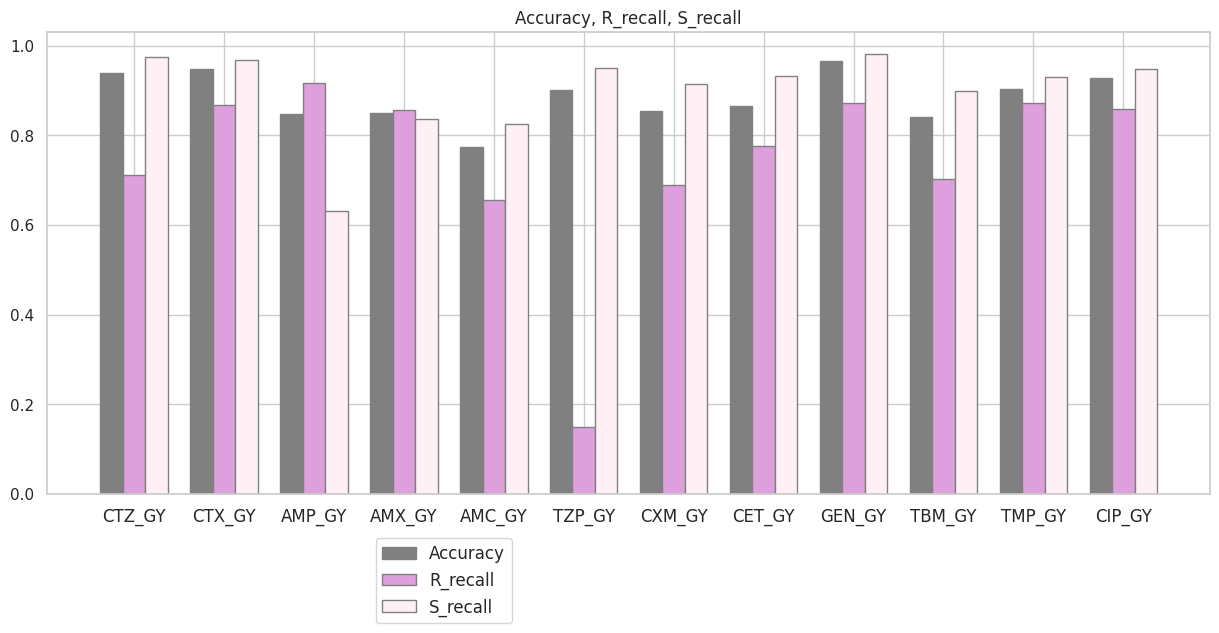

In [53]:
try:
  # makes a directory for all your plot images
  os.mkdir('/content/drive/My Drive/EColi_ML_Plots')
except:
  print("A directory was already created to store your plot")

# filtering for all the rows that contain GY features
LG_metrics = pd.read_csv("/content/drive/MyDrive/EColi_ML_CSV_files/LG_metrics_df.csv")
GY_filter = [drug_combo for drug_combo in LG_metrics['Drug_combo'] if drug_combo.endswith("GY")]
GY_df = LG_metrics.loc[LG_metrics["Drug_combo"].isin(GY_filter)]

# Figure Size
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize =(15, 6))

# Adding title
plt.title('Accuracy, R_recall, S_recall', fontsize = 12)

# Variables to be plotted
x = np.arange(len(GY_df["Drug_combo"]))
acc = list(GY_df["Accuracy"])
R_rec = list(GY_df["R_recall"])
S_rec = list(GY_df["S_recall"])

# Plotting barcharts
acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="grey", edgecolor="gray")
rrec_bar=plt.bar(x, height= R_rec, width=0.25, color="plum", edgecolor="gray")
srec_bar=plt.bar(x+0.25, height= S_rec, width=0.25, color="lavenderblush", edgecolor="gray")

plt.xticks([r for r in range(len(GY_df["Drug_combo"]))],
            GY_df["Drug_combo"], fontsize = 12)

#legend
fig.legend([acc_bar,rrec_bar,srec_bar],["Accuracy", "R_recall", "S_recall"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

# Saving bargraph into our new directory
plt.savefig('/content/drive/My Drive/EColi_ML_Plots/LG_GY_Accuracy_and_Recall_Scores.jpg',dpi=400, bbox_inches="tight")

# Show Plot
plt.show()


Notice for instance the antibiotic **CTZ**, when we only pay attention to the Accuracy, we would conclude that our model is doing fairly well, however, when examine recall we can clearly see that the Recall for Resistance is noticeably lower than for Susceptibility. Therefore, for imbalanced classes, Accuracy is usually not the best metric to use.


***OPEN QUESTION:***

Look at the graph. Is recall typically better for R or S? why do you think that’s the case?


Thanks for making it this far! We have accomplished the objectives of this notebook. We learned the basics of how logistic regression works and learned how to make functions in order to run this model using Moragadivand's *E. coli* dataset. Now we will move on to our next ML model, [Random Forest](https://colab.research.google.com/drive/1a-DVckHvYOMehMZJWnX4Vu8m6t7ElXQy?usp=sharing) and learn a bit more about tree-based models in general.